In [1]:
import numpy as np
from scipy import sparse
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import speech as hwutil
import classify

In [2]:
print("Reading data")
tarfname = "data/speech.tar.gz"
speech = hwutil.read_files(tarfname)

Reading data
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels


In [3]:
print("Reading unlabeled data")
unlabeled = hwutil.read_unlabeled(tarfname, speech)

Reading unlabeled data
(43342, 7916)


## include all prediction and fixed iteration with subsample 20%

In [4]:
def semi_all(data, unlabelx, loop=10):
    train_x = data.trainX
    train_y = data.trainy
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    train_acc = np.zeros(loop)
    valid_acc = np.zeros(loop)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(loop):
        print(f'{i}th iteration')
        print('  training')
        model.fit(train_x, train_y)
        print('  accuracy')
        train_acc[i] = classify.evaluate(speech.trainX, speech.trainy, model)
        valid_acc[i] = classify.evaluate(speech.devX, speech.devy, model)
        pred = model.predict(unlabelx)
        dif = np.sum(pred != prev)
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        train_x = sparse.vstack([train_x, unlabelx])
        train_y = np.concatenate([train_y, pred])
        if not i % 9:
            print(f'{i}th iteration')
    
    return train_acc, valid_acc,  model

In [5]:
train_acc_all, valid_acc_all, model_all = semi_all(speech, unlabeled.X)

0th iteration
  training
  accuracy
  Accuracy 0.9832951945080092
  Accuracy 0.4082125603864734
 43316 different
  stack unlabeled
0th iteration
1th iteration
  training
  accuracy
  Accuracy 0.8862700228832951
  Accuracy 0.41304347826086957
 1236 different
  stack unlabeled
2th iteration
  training
  accuracy
  Accuracy 0.85720823798627
  Accuracy 0.41545893719806765
 73 different
  stack unlabeled
3th iteration
  training
  accuracy
  Accuracy 0.84279176201373
  Accuracy 0.4057971014492754
 18 different
  stack unlabeled
4th iteration
  training
  accuracy
  Accuracy 0.8338672768878719
  Accuracy 0.39855072463768115
 11 different
  stack unlabeled
5th iteration
  training
  accuracy
  Accuracy 0.825629290617849
  Accuracy 0.39855072463768115
 11 different
  stack unlabeled
6th iteration
  training
  accuracy
  Accuracy 0.820137299771167
  Accuracy 0.40096618357487923
 6 different
  stack unlabeled
7th iteration
  training
  accuracy
  Accuracy 0.8164759725400458
  Accuracy 0.39855072

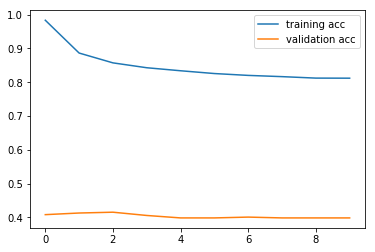

In [6]:
plt.plot(train_acc_all, label='training acc')
plt.plot(valid_acc_all, label='validation acc')
plt.legend()
plt.savefig('image/semi_all_10iter')
plt.show()

In [8]:
print("Writing pred file")
hwutil.write_pred_kaggle_file(unlabeled, model_all, "data/speech-pred.csv", speech)

Writing pred file


## include all prediction and stop as prediction change smaller than 20 or reached max_iter

In [5]:
def semi_diff(data, unlabelx, max_iter=20):
    train_x = data.trainX
    train_y = data.trainy
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    train_acc = np.zeros(max_iter)
    valid_acc = np.zeros(max_iter)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(max_iter):
        print(f'{i}th iteration')
        print('  training')
        model.fit(train_x, train_y)
        print('  accuracy')
        train_acc[i] = classify.evaluate(speech.trainX, speech.trainy, model)
        valid_acc[i] = classify.evaluate(speech.devX, speech.devy, model)
        pred = model.predict(unlabelx)
        dif = np.sum(pred != prev)
        if dif < 100:
            break
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        train_x = sparse.vstack([train_x, unlabelx])
        train_y = np.concatenate([train_y, pred])
        if not i % 9:
            print(f'{i}th iteration')
    
    return train_acc, valid_acc, model

In [10]:
train_acc_diff, valid_acc_diff, model_diff = semi_diff(speech, unlabeled.X)

0th iteration
  training
  accuracy
  Accuracy 0.9832951945080092
  Accuracy 0.4082125603864734
 43316 different
  stack unlabeled
0th iteration
1th iteration
  training
  accuracy
  Accuracy 0.8862700228832951
  Accuracy 0.41304347826086957
 1236 different
  stack unlabeled
2th iteration
  training
  accuracy
  Accuracy 0.85720823798627
  Accuracy 0.41545893719806765


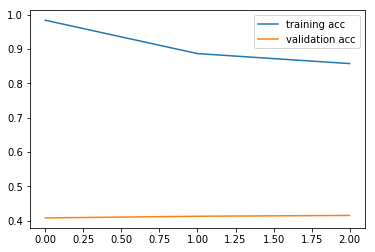

In [11]:
plt.plot(train_acc_diff[train_acc_diff>0], label='training acc')
plt.plot(valid_acc_diff[valid_acc_diff>0], label='validation acc')
plt.legend()
plt.savefig('image/semi_all_100_diff')
plt.show()

In [18]:
print("Writing pred file")
hwutil.write_pred_kaggle_file(unlabeled, model_diff, "data/speech-pred.csv", speech)

Writing pred file


## include most confident prediction as confident score with prediction change stopping criteria

In [7]:
def semi_confid(data, unlabelx, confid_level=5, stop_diff=100, max_iter=25):
    train_x = data.trainX
    train_y = data.trainy
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    train_acc = np.zeros(max_iter)
    valid_acc = np.zeros(max_iter)
    num_diff = np.zeros(max_iter)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(max_iter):
        print(f'{i}th iteration')
        print('  training')
        model.fit(train_x, train_y)
        print('  accuracy')
        train_acc[i] = classify.evaluate(speech.trainX, speech.trainy, model)
        valid_acc[i] = classify.evaluate(speech.devX, speech.devy, model)
        pred = model.predict(unlabelx)
        dif = np.sum(pred != prev)
        num_diff[i] = dif
        if dif < stop_diff:
            break
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        confid = np.sum(model.decision_function(unlabelx) > 0,axis=1)
        ind = np.where((0 < confid) & (confid <= confid_level))
        print(confid)
        train_x = sparse.vstack([train_x, unlabelx[ind]])
        train_y = np.concatenate([train_y, pred[ind]])
        if not i % 9:
            print(f'{i}th iteration')
    
    return num_diff, train_acc, valid_acc, model

In [8]:
diff_confid, train_acc_confid, valid_acc_confid, model_confid = semi_confid(speech, unlabeled.X, stop_diff=20)

0th iteration
  training
  accuracy
  Accuracy 0.9832951945080092
  Accuracy 0.4082125603864734
 43316 different
  stack unlabeled
[1 0 1 ... 1 0 0]
0th iteration
1th iteration
  training
  accuracy
  Accuracy 0.922654462242563
  Accuracy 0.4033816425120773
 5699 different
  stack unlabeled
[1 1 1 ... 1 1 1]
2th iteration
  training
  accuracy
  Accuracy 0.8652173913043478
  Accuracy 0.40096618357487923
 2600 different
  stack unlabeled
[1 1 1 ... 1 1 1]
3th iteration
  training
  accuracy
  Accuracy 0.8265446224256293
  Accuracy 0.391304347826087
 1385 different
  stack unlabeled
[1 1 1 ... 1 1 1]
4th iteration
  training
  accuracy
  Accuracy 0.8020594965675057
  Accuracy 0.39371980676328505
 864 different
  stack unlabeled
[1 1 1 ... 1 1 1]
5th iteration
  training
  accuracy
  Accuracy 0.782837528604119
  Accuracy 0.391304347826087
 549 different
  stack unlabeled
[1 1 1 ... 1 1 1]
6th iteration
  training
  accuracy
  Accuracy 0.7679633867276888
  Accuracy 0.391304347826087
 417 d

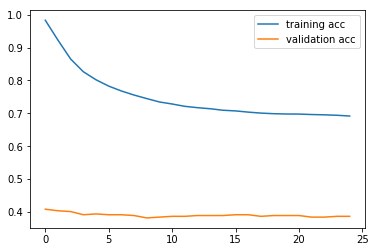

In [9]:
plt.plot(train_acc_confid[train_acc_confid>0], label='training acc')
plt.plot(valid_acc_confid[valid_acc_confid>0], label='validation acc')
plt.legend()
plt.savefig('image/semi_confid_5_25iter')
plt.show()

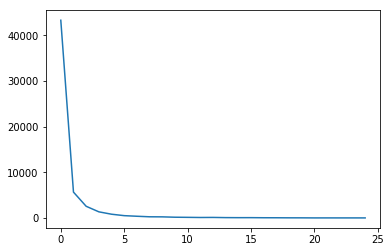

In [18]:
plt.plot(diff_confid[diff_confid>0])

In [37]:
model.decision_function(unlabeled.X).shape

(43342, 19)

In [15]:
print("Writing pred file")
hwutil.write_pred_kaggle_file(unlabeled, model_confid, "data/speech-pred.csv", speech)

Writing pred file


In [16]:
diff_confid3, acc_confid3, model_confid3 = semi_confid(speech, unlabeled.X, confid_level=3)

0th iteration
  training
  accuracy
 43316 different
  stack unlabeled
[1 0 1 ... 1 0 0]
0th iteration
1th iteration
  training
  accuracy
 5720 different
  stack unlabeled
[1 1 1 ... 1 1 1]
2th iteration
  training
  accuracy
 2606 different
  stack unlabeled
[1 1 1 ... 1 1 1]
3th iteration
  training
  accuracy
 1378 different
  stack unlabeled
[1 1 1 ... 1 1 1]
4th iteration
  training
  accuracy
 838 different
  stack unlabeled
[1 1 1 ... 1 1 1]
5th iteration
  training
  accuracy
 559 different
  stack unlabeled
[1 1 1 ... 1 1 1]
6th iteration
  training
  accuracy
 399 different
  stack unlabeled
[1 1 1 ... 1 1 1]
7th iteration
  training
  accuracy
 300 different
  stack unlabeled
[1 1 1 ... 1 1 1]
8th iteration
  training
  accuracy
 251 different
  stack unlabeled
[1 1 1 ... 1 1 1]
9th iteration
  training
  accuracy
 198 different
  stack unlabeled
[1 1 1 ... 1 1 1]
9th iteration
10th iteration
  training
  accuracy
 194 different
  stack unlabeled
[1 1 1 ... 1 1 1]
11th iter

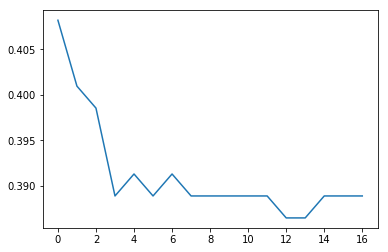

In [17]:
plt.plot(acc_confid3[acc_confid3>0])

In [18]:
print("Writing pred file")
hwutil.write_pred_kaggle_file(unlabeled, model_confid, "data/speech-pred.csv", speech)

Writing pred file


In [4]:
def semi_confid2(data, unlabelx, stop_diff=100, max_iter=25):
    train_x = data.trainX
    train_y = data.trainy
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    acc = np.zeros(max_iter)
    num_diff = np.zeros(max_iter)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(max_iter):
        print(f'{i}th iteration')
        print('  training')
        model.fit(train_x, train_y)
        print('  accuracy')
        acc[i] = metrics.accuracy_score(data.devy, model.predict(data.devX))
        pred = model.predict(unlabelx)
        dif = np.sum(pred != prev)
        num_diff[i] = dif
        if dif < stop_diff:
            break
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        confid = np.sum(model.predict_proba(unlabelx) > 0.5, axis=1)
        ind = np.where(confid==1)
        print('  ', len(confid), 'added')
        train_x = sparse.vstack([train_x, unlabelx[ind]])
        train_y = np.concatenate([train_y, pred[ind]])
        if not i % 9:
            print(f'{i}th iteration')
    
    return num_diff, acc, model

In [ ]:
diff_confid_2, acc_confid_2, model_confid_2 = semi_confid2(speech, unlabeled.X)

0th iteration
  training
  accuracy
 43316 different
  stack unlabeled
   43342 added
0th iteration
1th iteration
  training
  accuracy
 6406 different
  stack unlabeled
   43342 added
2th iteration
  training
  accuracy
 2594 different
  stack unlabeled
   43342 added
3th iteration
  training


In [5]:
cls = LogisticRegression(solver='liblinear')
cls.fit(speech.trainX, speech.trainy)
print(cls.predict(unlabeled.X))

[10  3  3 ...  3  3 11]


array([[7.06419289e-03, 2.91268554e-03, 8.30796800e-04, ...,
        4.99065218e-03, 8.21260928e-04, 2.25863093e-02],
       [1.14746859e-01, 1.19548906e-02, 3.79678155e-04, ...,
        2.95461788e-03, 4.40363267e-03, 3.40026109e-03],
       [5.75067139e-04, 4.18990081e-04, 2.29340969e-03, ...,
        2.92749053e-04, 1.78221583e-03, 2.57024069e-03],
       ...,
       [9.31283059e-03, 8.37221565e-03, 1.33818463e-03, ...,
        2.12743747e-02, 2.26037353e-02, 7.41689387e-02],
       [2.23031045e-04, 1.06309738e-03, 1.00840673e-02, ...,
        6.64920391e-04, 2.49113263e-03, 5.45834272e-03],
       [3.31691278e-05, 7.45167482e-03, 2.14959049e-03, ...,
        6.71901164e-03, 5.16502008e-03, 3.78823202e-03]])

In [12]:
cls.decision_function(unlabeled.X)[2]

array([-7.43638442, -7.75318393, -6.05131352,  0.34278717, -5.50043402,
       -4.92761681, -5.1828323 , -5.80309628, -8.90144539, -6.26736315,
       -2.63021763, -3.16859177, -8.17684396, -8.19786341, -0.84184014,
       -8.61420999, -8.11184477, -6.30402047, -5.93706935])

## Extract feature, set threshold on how many

## TF-IDF Weighting

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
speech.tfidf_vect = TfidfVectorizer(min_df=12, stop_words='english')
speech.tfidf_trainX = speech.tfidf_vect.fit_transform(speech.train_data)
speech.tfidf_devX = speech.tfidf_vect.transform(speech.dev_data)

In [13]:
unlabeled.tfidf_X = speech.tfidf_vect.transform(unlabeled.data)

In [14]:
def semi_all_tfidf(data, unlabelx, loop=10):
    train_x = data.tfidf_trainX
    train_y = data.trainy
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    train_acc = np.zeros(loop)
    valid_acc = np.zeros(loop)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(loop):
        print(f'{i}th iteration')
        print('  training')
        model.fit(train_x, train_y)
        print('  accuracy')
        train_acc[i] = classify.evaluate(speech.tfidf_trainX, speech.trainy, model)
        valid_acc[i] = classify.evaluate(speech.tfidf_devX, speech.devy, model)
        pred = model.predict(unlabelx)
        dif = np.sum(pred != prev)
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        train_x = sparse.vstack([train_x, unlabelx])
        train_y = np.concatenate([train_y, pred])
        if not i % 9:
            print(f'{i}th iteration')
    
    return train_acc, valid_acc,  model

In [17]:
train_acc_tfidf_all, valid_acc_tfidf_all, model_tfidf_all = semi_all_tfidf(speech, unlabeled.tfidf_X)

0th iteration
  training
  accuracy
  Accuracy 0.4812356979405034
  Accuracy 0.36231884057971014
 43342 different
  stack unlabeled
0th iteration
1th iteration
  training
  accuracy
  Accuracy 0.43249427917620137
  Accuracy 0.34541062801932365
 2950 different
  stack unlabeled
2th iteration
  training
  accuracy
  Accuracy 0.4260869565217391
  Accuracy 0.34541062801932365
 528 different
  stack unlabeled
3th iteration
  training
  accuracy
  Accuracy 0.422883295194508
  Accuracy 0.34541062801932365
 229 different
  stack unlabeled
4th iteration
  training
  accuracy
  Accuracy 0.41990846681922195
  Accuracy 0.34541062801932365
 131 different
  stack unlabeled
5th iteration
  training
  accuracy
  Accuracy 0.4183066361556064
  Accuracy 0.34299516908212563
 87 different
  stack unlabeled
6th iteration
  training
  accuracy
  Accuracy 0.41807780320366134
  Accuracy 0.34299516908212563
 60 different
  stack unlabeled
7th iteration
  training
  accuracy
  Accuracy 0.41762013729977115
  Accu

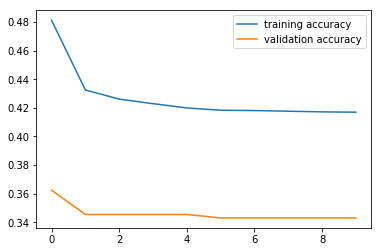

In [35]:
plt.plot(train_acc_tfidf_all, label='training accuracy')
plt.plot(valid_acc_tfidf_all, label='validation accuracy')
plt.legend()
plt.savefig('image/semi_all_tfidf')
plt.show()

In [33]:
from sklearn.decomposition import TruncatedSVD

def semi_all_svd(data, unlabelx, loop=10):
    train_x = data.tfidf_trainX.toarray()
    train_y = data.trainy
    unlabelx = unlabelx.toarray()
    N = unlabelx.shape[0]
#     ind = np.random.choice(np.arange(N), size=N//5, replace=False)
#     subx = unlabelx[ind]
    train_acc = np.zeros(loop)
    valid_acc = np.zeros(loop)
    svd = TruncatedSVD(n_components=10)
    svd.fit(train_x)
    model = LogisticRegression(solver='liblinear')
    prev = np.zeros(N)
    
    for i in range(loop):
        print(f'{i}th iteration')
        print('  training')
        model.fit(np.concatenate([train_x,svd.transform(train_x)], axis=1), train_y)
        print('  accuracy')
        train_acc[i] = classify.evaluate(np.concatenate([speech.tfidf_trainX.toarray(), svd.transform(speech.tfidf_trainX)], axis=1),
                                         speech.trainy, model)
        valid_acc[i] = classify.evaluate(np.concatenate([speech.tfidf_devX.toarray(), svd.transform(speech.tfidf_devX)], axis=1),
                                         speech.devy, model)
        pred = model.predict(np.concatenate([unlabelx, svd.transform(unlabelx)], axis=1))
        dif = np.sum(pred != prev)
        prev = pred
        print(f' {dif} different')
        print('  stack unlabeled')
        train_x =np.concatenate([train_x, unlabelx],axis=0)
        train_y = np.concatenate([train_y, pred])
        if not i % 9:
            print(f'{i}th iteration')
    
    return train_acc, valid_acc,  model

In [34]:
result = semi_all_svd(speech, unlabeled.tfidf_X)

0th iteration
  training
  accuracy
  Accuracy 0.482837528604119
  Accuracy 0.36231884057971014
 43342 different
  stack unlabeled
0th iteration
1th iteration
  training
  accuracy
  Accuracy 0.43546910755148743
  Accuracy 0.34299516908212563
 2977 different
  stack unlabeled
2th iteration
  training
  accuracy
  Accuracy 0.428604118993135
  Accuracy 0.34782608695652173
 562 different
  stack unlabeled
3th iteration
  training
  accuracy
  Accuracy 0.4240274599542334
  Accuracy 0.34541062801932365
 264 different
  stack unlabeled
4th iteration
  training
  accuracy
  Accuracy 0.42242562929061783
  Accuracy 0.34541062801932365
 133 different
  stack unlabeled
5th iteration
  training
  accuracy
  Accuracy 0.4208237986270023
  Accuracy 0.34541062801932365
 92 different
  stack unlabeled
6th iteration
  training
  accuracy
  Accuracy 0.42013729977116704
  Accuracy 0.34541062801932365
 66 different
  stack unlabeled
7th iteration
  training
  accuracy
  Accuracy 0.41922196796338673
  Accur

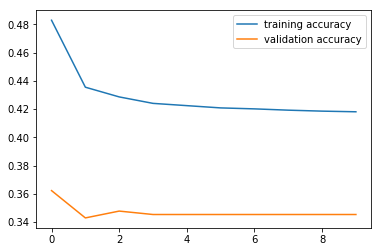

In [37]:
plt.plot(result[0], label='training accuracy')
plt.plot(result[1], label='validation accuracy')
plt.legend()
plt.savefig('image/semi_all_tfidfsvd')
plt.show()